AMAÇ : OTOMOBİLLERİN YAKIN VERİMLİLİĞİNİ TAHMİN ETMEK
VERİSETİ : AUTO MPG --1970 LERİN SONU 1980 LERİN BAŞI
- ARAÇLARA AİT SİLİNDİRLER,YER DEĞİŞTİRME , BEYGİR GÜCÜ VE AĞIRLIK GİBİ ÖZELLİKLER

***1-INSTALL AND IMPORT LIBRARIES***

In [1]:
# görselleştirmek için seaborn kütüphanesini kullanacağız
!pip install -q seaborn

In [2]:
# 1-importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# numpy çıktılarının okunmasını kolaylaştırmak için
np.set_printoptions(precision=3, suppress=True)


In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.15.0


***2-LOAD DATASET***

In [4]:
# 2-Download Dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                                          na_values='?', comment='\t',
                                                                    sep=' ', skipinitialspace=True)







***3-PREPROCESSING DATA***

In [5]:
# verinin bir kopyasını alıyoruz--ÖNLEM
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
# verisetinde kayıp olan veri var mı kontrol ediyoruz
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
# Bazı bilgiler boş olduğu için boşlukları temizlemekle başlayalım
dataset = dataset.dropna()
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
# boşluklar temizlendi şimdi orijin satırına dikkat ettiğimizde sayısal değil categoriktir.
# Dolayısıyla bunu sayısal verilere dönüştürmemiz gerek
# Bunun içinde pd.get_dummies modülünü kullanacaz
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

<ipython-input-8-ed48596c316e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


In [10]:
# Veriyi EĞitim ve Test veri setlerine ayıralım (%80 ttain_dataset-%20 test_dataset)
train_dataset = dataset.sample(frac = 0.8,random_state= 0)
test_dataset = dataset.drop(train_dataset.index)

In [11]:
print(train_dataset.shape)
print(test_dataset.shape)

(314, 10)
(78, 10)


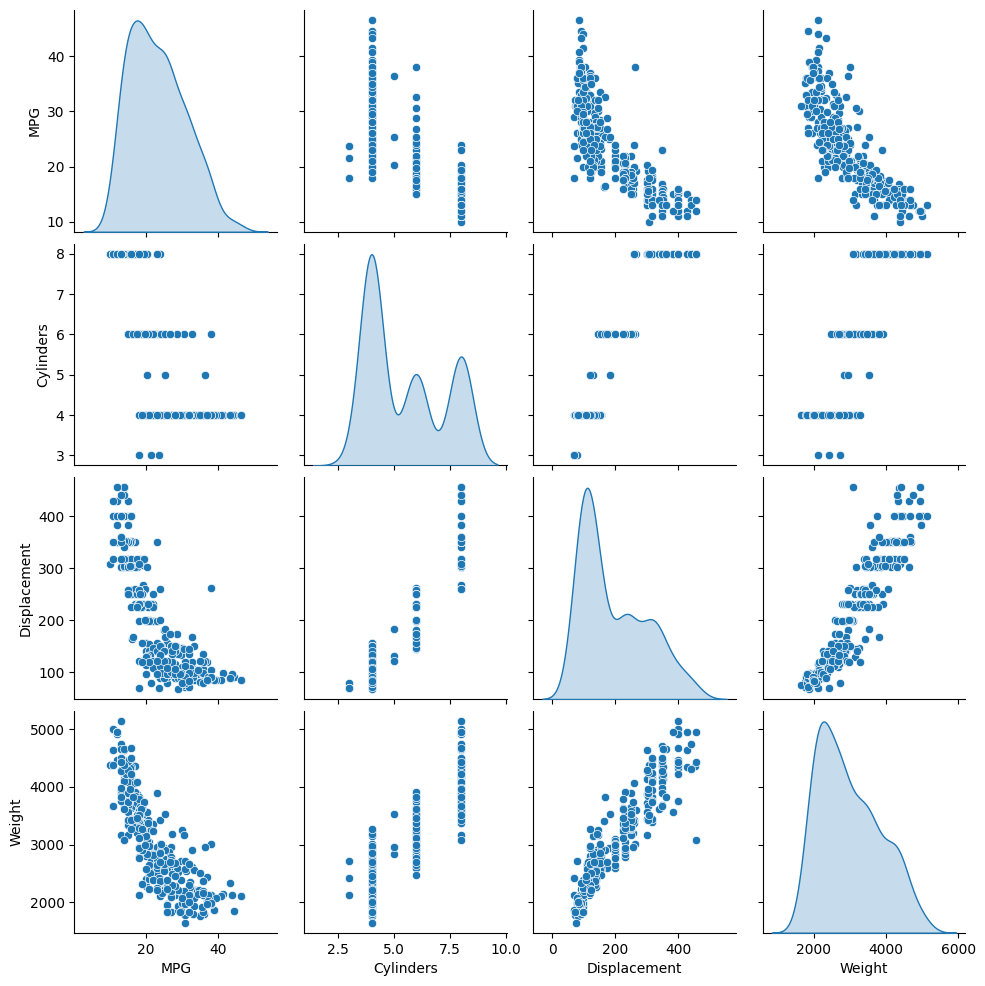

In [12]:
# sütunlarımızdaki bilgilerimizi görselleştirelim
sns.pairplot(train_dataset[["MPG","Cylinders","Displacement","Weight"]],diag_kind = "kde")

In [13]:
# Sayısal genel özelliklerine bakalım
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [14]:
# Tekrar kopyasını alalım ve etiketlerle(labels) özellikleri(features) ayıralım
# FEATURES AND LABELS OLARAK İKİ KISMA AYIRIYORUZ.(BAĞIMLI DEĞİŞKEN VE BAĞIMSIZ DEĞİŞKEN)
#BAĞIMLI DEĞİŞKENLER
train_features = train_dataset.copy()
test_features = test_dataset.copy()
#-----------------------------------------------------------------------------------------------
# .pop() metodu train_features datasından 'MPG' yi kaldırır ve train_labels 'a tanımlar.Dolayısıyla BAĞIMLI DEĞİŞKEN ORTAYA ÇIKAR
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')
# Bütün verileri aynı cinse çeciriyoruz sorun çıkmaması için
train_features= train_features.astype('float32')
test_features = test_features.astype('float32')

***4-NORMALIZATION***

- Farkli olcekler ve araliklar kullanan ozellikleri NORMALLESTİRMEK iyi bir uygulamadir.
Ozelikler model agirliklari ile carpildigi icin ozellik degerleri onemlidir
Dolayisiyla girdilerin ölçeği ---- çıktıların ölçeğini ve gradyanlarin ölçeğini etkiler

Bu model ozellik normalleşmesi olmadan yakinsayabilir ama normalleştirmek egitimi cok daha kararlı hale getirir

NOT; TEK ETKİN ÖZELİKLERİN NORMALLEŞTİRMENİN HİÇBİR AVANTAJI YOKTUR

In [15]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


In [16]:
#NORMALİZATİON
normalizer = tf.keras.layers.Normalization(axis=-1)

In [17]:
#adapt cagiriyoruz on işleme katmanini verilere uyduruyoruz
normalizer.adapt(np.array(train_features))

In [18]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


Katman çağırıldığnda her bir özellik bağımsız olarak normalleştirilmiş olarak giriş verilerini döndürür

In [19]:
first = np.array(train_features[:1])

with np.printoptions(precision =2,suppress = True):
  print("First Example :" , first)
  print()
  print("Normalized:",normalizer(first).numpy())

First Example : [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


***5-BUILD LINEAR REGRESSION***

*   a) Single-Input Linear Regression('Horsepower')
*   b) Multi-Input Linear Regression



In [20]:
# Derin bir sinir ağı oluşturmadan önce bir ve ya birkaç değişken kullnarak doğrusal regressionla başlıyoruz
# TEK DEĞİŞKENLİ DOĞRUSAL REGRESSİON
# "horsepower" özelliğini kullanarak "MPG" tahmini yapacaz
# İki aşamadan oluşur
  # 1- "horsepower" özelliğini vektorize edeceğiz
  #  2- " y = mx +b" denklemi kuracağız bunun için tf.keras.layers.Denese(1) kullansak yeterli olur
# input_shape bağımsız değişken tarafından veya model ilk kez çalıştırıldığında otomatik olarak ayarlanır

**a)Single Input Linear Regression**

In [21]:
horsepower = np.array(train_features["Horsepower"]) # numpy dizisi oluşturduk

horsepower_normalizer = layers.Normalization(input_shape=[1,],axis = None) # instant oluşturduk
horsepower_normalizer.adapt(horsepower) # horsepower verileriyle adapte olmasını sağladık

In [22]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units = 1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [23]:
# ilk 10 veri için bir deneme yapıyoruz çalışıp çalışmadığını kontrol etmek için
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 86ms/step


array([[-0.737],
       [-0.416],
       [ 1.36 ],
       [-1.033],
       [-0.934],
       [-0.367],
       [-1.107],
       [-0.934],
       [-0.244],
       [-0.416]], dtype=float32)

In [24]:
# Güzel çalışıyor şimdi compile edelim
horsepower_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.1),
    loss = "mean_absolute_error"
)

In [25]:
# 100 dönemlik bir eğitim oluşuturalım

%%time

history = horsepower_model.fit(
    train_features["Horsepower"],
    train_labels,
    epochs = 100,
    verbose = 0,
    validation_split = 0.2
)

CPU times: user 5.51 s, sys: 179 ms, total: 5.69 s
Wall time: 9.34 s


In [26]:
# history nesnesinde depolanan istatistikleri yani modelin eğitim ilerlemesini görelim
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.805962,4.183064,95
96,3.802860,4.199326,96
97,3.802921,4.190950,97
98,3.804572,4.185245,98
99,3.803613,4.206491,99


In [27]:
# Grafikle gösterelim
def plot_loss(history):
  plt.plot(history.history['loss'],label = "Loss")
  plt.plot(history.history["val_loss"],label = "Validation_Loss")
  plt.ylim([0,10])
  plt.xlabel("Epochs")
  plt.ylabel('Error(MPG)')
  plt.legend()
  plt.show()


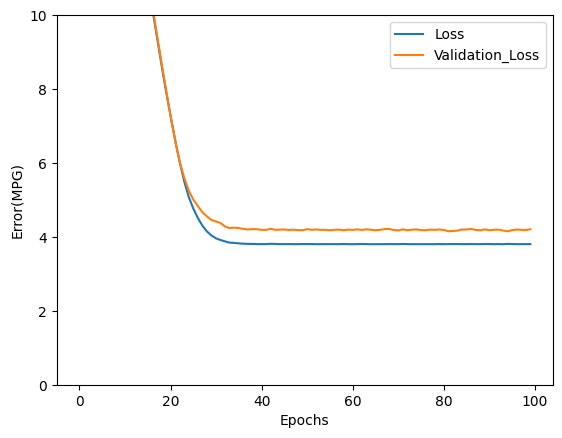

In [28]:
plot_loss(history)

In [29]:
hist_dict = history.history
print(hist_dict)

{'loss': [22.865516662597656, 22.061969757080078, 21.262752532958984, 20.462026596069336, 19.66234588623047, 18.860857009887695, 18.060955047607422, 17.260828018188477, 16.46173667907715, 15.664188385009766, 14.876519203186035, 14.09048843383789, 13.307308197021484, 12.522541046142578, 11.745542526245117, 10.959453582763672, 10.17690372467041, 9.418140411376953, 8.664626121520996, 7.943633556365967, 7.2802324295043945, 6.625201225280762, 6.031260967254639, 5.502251148223877, 5.078776836395264, 4.764342308044434, 4.5110273361206055, 4.3027262687683105, 4.145437717437744, 4.037170886993408, 3.959151029586792, 3.913329601287842, 3.8764379024505615, 3.8441216945648193, 3.8359413146972656, 3.824411630630493, 3.815417528152466, 3.8102519512176514, 3.809663772583008, 3.8044614791870117, 3.8042123317718506, 3.804734230041504, 3.813225030899048, 3.808072805404663, 3.8040542602539062, 3.8040854930877686, 3.8059275150299072, 3.803054094314575, 3.8041326999664307, 3.8060569763183594, 3.80493545532

In [30]:
# Sonuçları sonra kullanmak üzere test result setinde toplayalım
test_results = {}
test_results["horsepower_model"] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
    verbose = 0
)

In [32]:
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 4ms/step


In [33]:
def plot_horsepower(x,y):
    plt.scatter(train_features["Horsepower"],train_labels,label = "data")
    plt.plot(x,y,color ='k',label= "Predictions")
    plt.xlabel("Horsepower")
    plt.ylabel("MPG")
    plt.legend()
    plt.show()

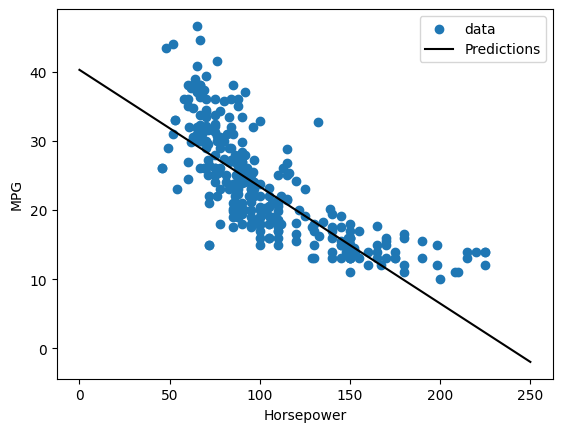

In [34]:
plot_horsepower(x,y)

b) Multi-Input Linear Regression

In [35]:
# çOKLU GİRİŞLİ REGRESYON İÇİN HEMEN HEMEN AYNI KURULUM YAPILIR
# ---Bu Model y = mx + b fakat buradaki m --> matris b----> vector olur
# Daha önce tanımlanan normalizer = tf.keras.layers.Normalizer(axis = -1) kullanılır

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units = 1)
])

In [36]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 217ms/step


array([[-0.87 ],
       [-1.336],
       [ 3.403],
       [-1.703],
       [-2.997],
       [ 0.121],
       [-3.209],
       [-3.003],
       [ 0.43 ],
       [-2.207]], dtype=float32)

In [37]:
# Modeli çağırdığımızda ağırlık matrisleri oluşturulacaktır.
# kernel ağırlıkları(m içindeki y = mx +b ) (9,1) olup olmadığına bakalım
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.614],
       [ 0.773],
       [ 0.532],
       [-0.219],
       [-0.349],
       [-0.344],
       [-0.358],
       [-0.529],
       [-0.13 ]], dtype=float32)>

In [38]:
# Modeli compile edelim
linear_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate = 0.1),
    loss = "mean_absolute_error"
)

In [39]:
# EĞİTİM (EPOCHS = 100)

%%time
history=linear_model.fit(
    train_features,
    train_labels,
    epochs = 100,
    verbose = 0, # Hata mesajlarının çıktıları için kullanılır 0 parametresi sadece önemli (hata mesajları) verir
    validation_split = 0.2
)

CPU times: user 6.01 s, sys: 151 ms, total: 6.17 s
Wall time: 12.2 s


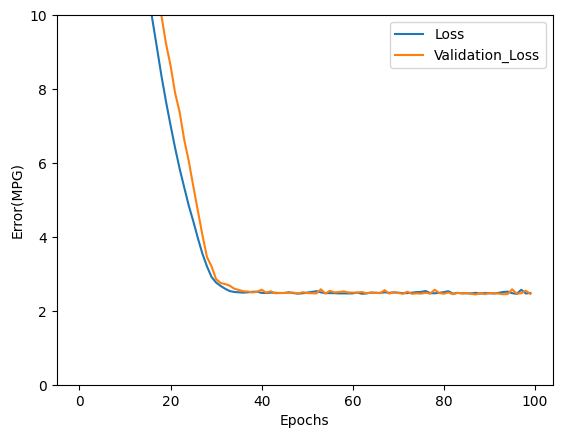

In [40]:
plot_loss(history)

Bütün girdilerin verilmesi sadece horsepower girdisine göre çok daha düşük bir eğim ve çok daha düşük doğrulama hatası sağlar

In [41]:
# Sonuçları daha sonra kullanmak üzere test verisinde toplayalım
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

***6-DNN MODEL(DEEP NEURAL NETWORK)***
- A)SINGLE-INPUT DNN
- B)MULTI-INPUT DNN

TEK GİRİŞLİ VE ÇOK GİRİŞLi MODELDEN FARKI GİZLİ DOĞRUSAL OLMAYAN KATMANLAR İLE GENİŞLETİLMESİ---> GİZLİ DENMESİNİN SEBEBİ DOĞRUDAN GİRŞ VE ÇIKIŞLARA BAĞLI OLMADIĞINDAN

KATMANLAR
1. normalizer
2. ReLU ---> doğrusal olmayan aktivasyon katmanı 2 adet
3. Dense tek çıkışlı katman



In [42]:
# TEk giriş ve çok girişli için kullanılmak üzere fonksiyon olarak model oluşturulması için tanımlıyorz
# Tek fark tek girşli için horsepower_normalizer kullanacağız ------çok girişli için normalizer kullanacez
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
    layers.Dense(64,activation = "relu"),
    layers.Dense(64,activation = "relu"),
    layers.Dense(1)
  ])

  model.compile(optimizer = tf.keras.optimizers.Adam(0.001), # hem tek hemde çoklu dnn için compile aynı olduğundan fonksiyon içerisine dahil ettik
                loss = 'mean_absolute_error')

  return model


A) SINGLE-INPUT DNN

In [43]:
# TEK GİRİŞTEN BAŞLAYALIM
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [44]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [45]:
# modeli eğitelim
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs = 100,
    validation_split = 0.2,
    verbose = 0

)

CPU times: user 6.38 s, sys: 197 ms, total: 6.58 s
Wall time: 11.5 s


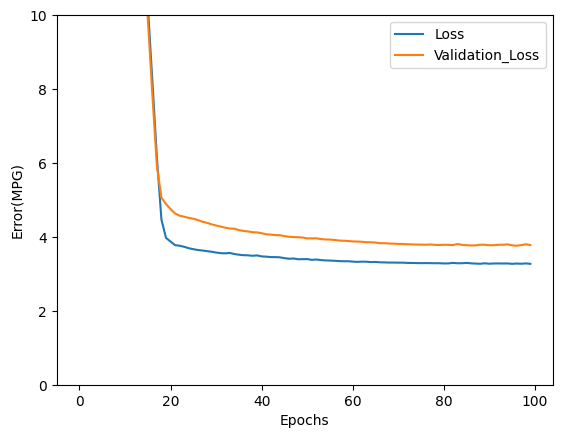

In [46]:
plot_loss(history)

dnn_horsepower_model tek girişli doğrusal regressiona göre biraz daha iyi sonuç verir

In [47]:
x = tf.linspace(0,250,251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


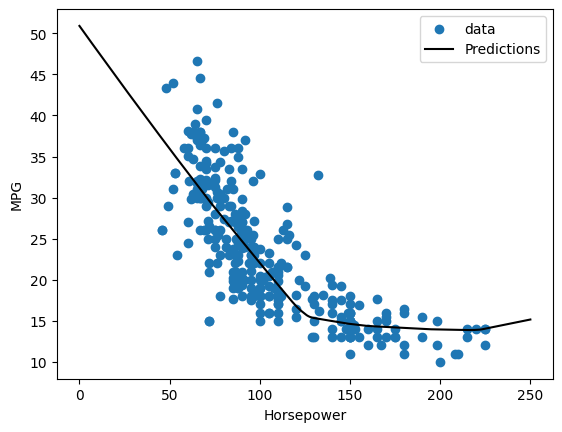

In [48]:
plot_horsepower(x,y)

In [49]:
# sonuçları daha sonra kullanılmak üzere kayıt ediyoruz

test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
    verbose = 0
)

B)MULTI-INPUT DNN MODEL

In [51]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


In [52]:
# Eğitelim
%%time

history = dnn_model.fit(
    train_features,
    train_labels,
    epochs = 100,
    verbose = 0,
    validation_split = 0.2
)

CPU times: user 5.84 s, sys: 207 ms, total: 6.05 s
Wall time: 11.4 s


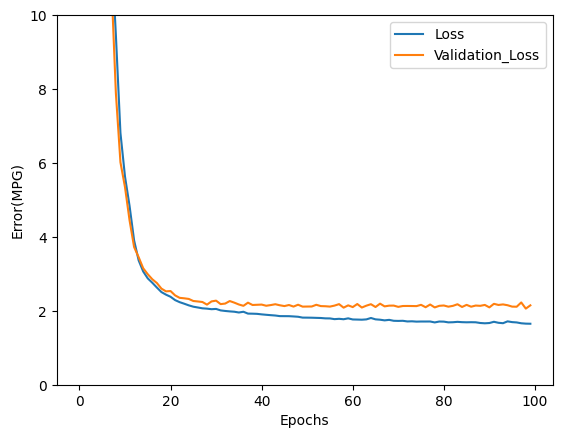

In [53]:
# Loss değerlerinin grafiğine bakalım
plot_loss(history)

In [54]:
# sonra kullanılmak üzere kaydedelim
test_results['dnn_model'] = dnn_model.evaluate(test_features,test_labels,verbose =0)

***7-RESULTS***

In [55]:
# SONUÇ : TÜM VERİLERE BALIP İNCELEYELİM
pd.DataFrame(test_results,index=["Mean Absolute Error[MPG]"]).T

,Mean Absolute Error[MPG]
horsepower_model,3.651105
linear_model,2.471138
dnn_horsepower_model,2.949775
dnn_model,1.663708


dnn_model değerleri diğerlerine oranla çok daha iyi tahminlerde bulunmaktadır

In [56]:
# DNN MODEL İLE TAHMİ YAPALIM
test_predictions = dnn_model.predict(test_features).flatten()

3/3 [==============================] - 0s 5ms/step


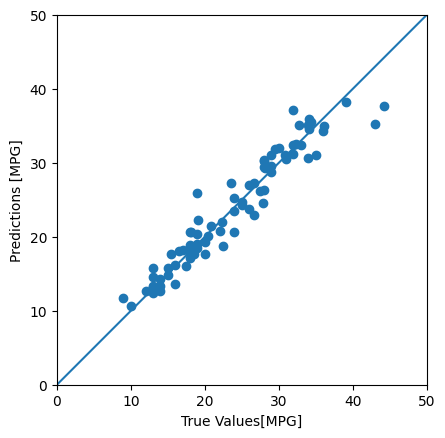

In [57]:
a = plt.axes(aspect = 'equal')
plt.scatter(test_labels,test_predictions)
plt.xlabel('True Values[MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0,50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)

Grafikte görüldüğü üzere iyi tahminler yapıyor

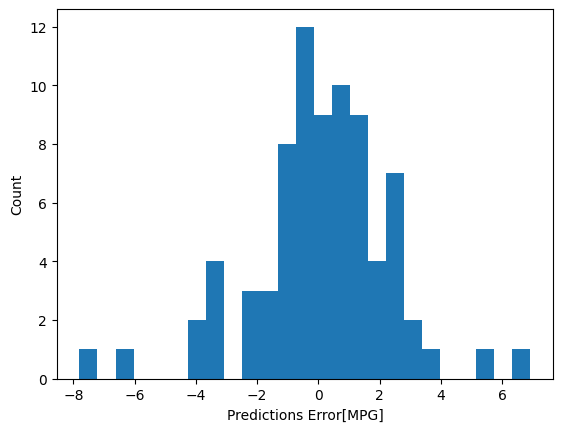

In [58]:
#HATA DAĞILIMINA BAKALIM
error = test_predictions - test_labels
plt.hist(error,bins = 25)
plt.xlabel("Predictions Error[MPG]")
_ = plt.ylabel('Count')

In [59]:
# model iyi tahminlerde bulunduğu için ileredie kullanmak üzere kaydediyoruz
dnn_model.save('dnn_model')

------------------------------------------------

In [60]:
# DENEME YAPALIM MODELİ TEKRAR YÜKLEYİP TAHMİN YAPTIRALIM
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = dnn_model.evaluate(
    test_features,
    test_labels,
    verbose =0
)

In [62]:
pd.DataFrame(test_results,index = ['Mean Absolute Error[MPG]']).T

,Mean Absolute Error[MPG]
horsepower_model,3.651105
linear_model,2.471138
dnn_horsepower_model,2.949775
dnn_model,1.663708
reloaded,1.663708
